In [36]:
# Recommender systems
# 1- Find similar users using KNN and K-means
# 2- Find useful movies
# 3- Compute prediction list of values (predicted rank)
# 4- Use evaluation metrics to analyze the quality of the prediction
# 5- Plot the chart
#
# Lucas cordeiro da Silva
# UFF - Universidade Federal Fluminense

# Ajudantes
import numpy as np
import pandas as pd
import operator
from math import sqrt

# Graficos
import matplotlib.pyplot as plt

# Metodos do sklearn
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors

# Metricas do sklearn e scipy
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import scipy.stats as stats

In [37]:
# Prototipo com funcoes para execucao dos metodos Kmeans e KNN
class RecommenderSystem(object):

    kmeans = None
    knn = None

    def __init__(self):
        pass

    # Encontrar o id dos usuários que pertencem ao mesmo cluster
    def ClusterIndicesNumpy(self, clustNum, labels_array):  # numpy
        return np.where(labels_array == clustNum)[0]

    # Definir peso de acordo com a distancia
    def DefineWeight(self, distance):
        return 1/(distance)**2
        # return 1

    # Distancia Euclidiana
    def euclideanDistance(self, user1, user2):
        return sqrt(sum(pow(a-b, 2) for a, b in zip(user1, user2)))

    # Encontrar os filmes que o usuário ativo já assistiu
    def getWatchedMovies(self, user_vector):  # numpy
        return dict((i, rating) for i, rating in enumerate(user_vector) if rating > 0)

    # Montar matriz usuariossimilares-filmes
    def mountSimilarUsersMatrix(self, matrix, users):
        return [matrix[user] for user in users]

    # Gerar predicao de notas para lista de filmes
    def predictRank(self, similarusers_matrix, activeuser_whatchedmovies, weights):

        # Contador de avaliacoes
        ratings = {1: 0, 2: 0, 3: 0, 4: 0, 5: 0}
        rp = {}

        # Predizer notas aos filmes
        for movie in activeuser_whatchedmovies:
            ratings = {1: 0, 2: 0, 3: 0, 4: 0, 5: 0}
            i = 0
            for user in similarusers_matrix:
                rating = user[movie]
                if rating > 0:
                    ratings[rating] += (1 * weights[i])
                i += 1
            rp.setdefault(movie, None)
            # Pega a nota com maior ocorrencia , ex: {1: 3, 2: 7, 3: 19, 4: 26, 5: 6} => 4
            rp[movie] = max(
                ratings.items(), key=operator.itemgetter(1))[0]

        return rp

    # Avaliar predicao usando Kendall Tau, MAE e RMSE
    def PredictionAccuracy(self, y_true, y_pred):
        tau = stats.kendalltau(y_true, y_pred)[0]
        mae = mean_absolute_error(y_true, y_pred)
        rmse = sqrt(mean_squared_error(y_true, y_pred))

        return {"Tau": tau, "MAE": mae, "RMSE": rmse}

    # Train K-Means
    def trainkmeans(self, X, k):
        # Instanciar o objeto kmeans e treinar
        self.kmeans = KMeans(n_clusters=k)
        self.kmeans.fit(X)

    # Train KNN
    def trainknn(self, X, k):
        # Instanciar o objeto KNN e treinar
        self.nbrs = NearestNeighbors(n_neighbors=k, metric='euclidean')
        self.nbrs.fit(X)

    # Pegar usuários similares usando K-Means
    def getSimilarUserskmeans(self, matrix, activeuser_vector):

        # Rótulo do cluster que cada usuário pertence
        users_clusterlabel = self.kmeans.labels_

        # Preveja o cluster mais próximo do usuário ativo
        activeuser_clusterlabel = self.kmeans.predict([activeuser_vector])

        # Encontrar todos os usuários que pertencem ao cluster do usuário ativo
        similarusers = self.ClusterIndicesNumpy(
            activeuser_clusterlabel, users_clusterlabel)

        # print(len(similarusers))

        # Gerar matrix usuariossimilares-filmes
        similarusers_matrix = self.mountSimilarUsersMatrix(
            matrix, similarusers)

        # criar vetor de distancias
        distances = [self.euclideanDistance(
            activeuser_vector, user_vector) for user_vector in similarusers_matrix]
        # criar vetor de pesos
        weights = [self.DefineWeight(distance) for distance in distances]

        return similarusers_matrix, weights

    # Pegar usuários similares usando KNN
    def getSimilarUsersknn(self, matrix, activeuser_vector):

        # Preveja quais sao os K usuarios mais proximos ao usuario ativo
        distances, similarusers = self.nbrs.kneighbors([activeuser_vector])

        # print(len(similarusers[0]))

        # Gerar matrix usuariossimilares-filmes
        similarusers_matrix = self.mountSimilarUsersMatrix(
            matrix, similarusers[0])

        # criar vetor de pesos
        weights = [self.DefineWeight(distance) for distance in distances[0]]

        return similarusers_matrix, weights

    # Exibe os gráficos
    def renderCharts(self, results, k):

        # Tau
        kmeans_points_tau = [_["kmeans"]["tau"] for _ in results]
        knn_points_tau = [_["knn"]["tau"] for _ in results]
        plt.figure(1)
        plt.plot(k, kmeans_points_tau, 'o-')
        plt.plot(k, knn_points_tau, 'o-')
        plt.title('K-Means(Azul) vs Knn(Laranja)')
        plt.ylabel('Kendall-Tau')
        plt.xlabel('K')
        plt.xticks(k)
        # plt.yticks(kmeans_points_mae + knn_points_mae)

        # MAE
        kmeans_points_mae = [_["kmeans"]["mae"] for _ in results]
        knn_points_mae = [_["knn"]["mae"] for _ in results]
        plt.figure(2)
        plt.plot(k, kmeans_points_mae, 'o-')
        plt.plot(k, knn_points_mae, 'o-')
        plt.title('K-Means(Azul) vs Knn(Laranja)')
        plt.ylabel('MAE')
        plt.xlabel('K')
        plt.xticks(k)
        # plt.yticks(kmeans_points_mae + knn_points_mae)

        # RMSE
        kmeans_points_rmse = [_["kmeans"]["rmse"] for _ in results]
        knn_points_rmse = [_["knn"]["rmse"] for _ in results]
        plt.figure(3)
        plt.plot(k, kmeans_points_rmse, 'o-')
        plt.plot(k, knn_points_rmse, 'o-')
        plt.title('K-Means(Azul) vs Knn(Laranja)')
        plt.ylabel('RMSE')
        plt.xlabel('K')
        plt.xticks(k)
        # plt.yticks(kmeans_points_rmse + knn_points_rmse)

        plt.show()

In [38]:
# Classe com funcoes para importar o dataset e construir as matrizes para input
class Data(object):

    # Matriz Geral
    matrix = []
    # Matriz de treinamento
    matrixtrain = []
    # Matriz de teste
    matrixtest = []
    # Tamanho da matriz de treinamento
    trainpercentage = 0.0

    def __init__(self, ratings_path, trainpercentage):
        self.trainpercentage = trainpercentage
        self.LoadData(ratings_path)

    # Carregar Base de dados
    def LoadData(self, ratings_path):

        # Ler arquivo
        colname = ['user', 'movie', 'rating', 'timestamp']
        df = pd.read_table(ratings_path, sep='\t', header=None,
                           names=colname, encoding="ISO-8859-1")

        # Determinar o número de usuários e filmes
        num_users = len(np.unique(df[['user']].values))
        num_movies = len(np.unique(df[['movie']].values))

        # Matriz de tamanho (num_users x num_movies) <=> (linha x coluna) <=> (mxn)
        self.matrix = [[0 for _ in range(num_movies)]
                       for _ in range(num_users)]

        # Fill in matrix from data
        for index in df.index:
            user = df['user'][index]
            movie = df['movie'][index]
            rating = df['rating'][index]
            self.matrix[user - 1][movie - 1] = rating

        last = int(round(num_users * self.trainpercentage))

        self.matrixtrain = self.matrix[: last]
        self.matrixtest = self.matrix[last:]

k:  1
k:  2
k:  3
k:  4
k:  5
k:  6
k:  7
k:  8
k:  9
k:  10
Metricas de avaliacao:  [{'kmeans': {'tau': 0.2843163403391698, 'mae': 0.8461993554668084, 'rmse': 1.1474719305221397}, 'knn': {'tau': 0.1600173867427244, 'mae': 1.9815343672776324, 'rmse': 2.3166637440301963}}, {'kmeans': {'tau': 0.26103509331233793, 'mae': 0.8757872880514325, 'rmse': 1.184518893608388}, 'knn': {'tau': 0.18371447936498825, 'mae': 1.7662020208438298, 'rmse': 2.1294681963011346}}, {'kmeans': {'tau': 0.2590472659545516, 'mae': 0.8814738949071662, 'rmse': 1.1911672919734166}, 'knn': {'tau': 0.1939420728846388, 'mae': 1.6465877294938438, 'rmse': 2.021086364172108}}, {'kmeans': {'tau': 0.25668948875082204, 'mae': 0.8865093748863977, 'rmse': 1.1994101846927536}, 'knn': {'tau': 0.19869282015679463, 'mae': 1.5560796349131403, 'rmse': 1.9342077172340864}}, {'kmeans': {'tau': 0.2503564492602635, 'mae': 0.8971819337189307, 'rmse': 1.2126173111550949}, 'knn': {'tau': 0.19653640852027424, 'mae': 1.4978636614209735, 'rmse'

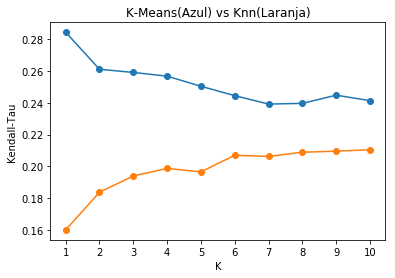

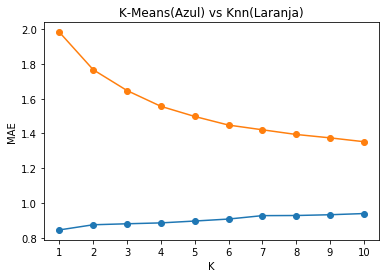

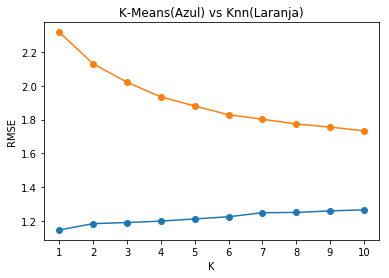

In [39]:
# Inicia tudo
def main():
    # Parametros de funcionamento do K
    k_min = 1
    k_max = 10
    step = 1

    # Lista de k vizinhos a serem estudados
    kvalues = [k for k in range(k_min, (k_max + step), step)]

    # Tamanho da matrix de treinamento, ex: 0.5 -> 50% treinamento e 50% teste
    trainpercentage = 0.70

    # Ler dataset
    # The full u data set, 100000 ratings by 943 users on 1682 items.
    # Each user has rated at least 20 movies.  Users and items are
    # numbered consecutively from 1.  The data is randomly
    # ordered. This is a tab separated list of
    # user id | item id | rating | timestamp.
    # The time stamps are unix seconds since 1/1/1970 UTC
    # https://grouplens.org/datasets/movielens/100k/
    data = Data("u.data", trainpercentage)

    # Lista com os resultados finais variando k
    results = []

    # matrix numpy
    X = np.array(data.matrixtrain)

    # Criar objeto prototipo
    RecommenderSystemd = RecommenderSystem()

    # para cada valor de k
    for k in kvalues:

        # Metricas de avaliacao
        metrics = {"kmeans": {"tau": [], "mae": [], "rmse": []},
                   "knn": {"tau": [], "mae": [], "rmse": []}}

        print("k: ", k)

        # 1- Treinar conjundo de dados
        RecommenderSystemd.trainkmeans(X, k)
        RecommenderSystemd.trainknn(X, k)

        # para cada usuario de teste
        for user in data.matrixtest:

            # 2- Definir vetor do usuário ativo e rank real
            activeuser_vector = user
            activeuser_whatchedmovies = RecommenderSystemd.getWatchedMovies(
                activeuser_vector)

            # 3- Encontrar usuários similares ao usuário ativo
            # K-Means
            similarusers_matrix, weightskmeans = RecommenderSystemd.getSimilarUserskmeans(
                data.matrixtrain, activeuser_vector)

            # KNN
            similarusers_matrixknn, weightsknn = RecommenderSystemd.getSimilarUsersknn(
                data.matrixtrain, activeuser_vector)

            # 4- Predizer notas para lista de filmes
            # K-Means
            recommendation = RecommenderSystemd.predictRank(
                similarusers_matrix, activeuser_whatchedmovies, weightskmeans)

            # KNN
            recommendationknn = RecommenderSystemd.predictRank(
                similarusers_matrixknn, activeuser_whatchedmovies, weightsknn)

            # 5- Calcular Precisao da previsão
            # K-Means
            tau, mae, rmse = RecommenderSystemd.PredictionAccuracy(
                list(activeuser_whatchedmovies.values()), list(recommendation.values())).values()

            # K-NN
            tauknn, maeknn, rmseknn = RecommenderSystemd.PredictionAccuracy(
                list(activeuser_whatchedmovies.values()), list(recommendationknn.values())).values()

            # Guardar os calculos de precisao
            metrics["kmeans"]["tau"].append(tau)
            metrics["kmeans"]["mae"].append(mae)
            metrics["kmeans"]["rmse"].append(rmse)
            metrics["knn"]["tau"].append(tauknn)
            metrics["knn"]["mae"].append(maeknn)
            metrics["knn"]["rmse"].append(rmseknn)

        # Calcular a média do resultado das metricas
        metrics["kmeans"]["tau"] = np.nansum(
            metrics["kmeans"]["tau"]) / len(metrics["kmeans"]["tau"])
        metrics["kmeans"]["mae"] = np.sum(
            metrics["kmeans"]["mae"]) / len(metrics["kmeans"]["mae"])
        metrics["kmeans"]["rmse"] = np.sum(
            metrics["kmeans"]["rmse"]) / len(metrics["kmeans"]["rmse"])
        metrics["knn"]["tau"] = np.nansum(
            metrics["knn"]["tau"]) / len(metrics["knn"]["tau"])
        metrics["knn"]["mae"] = np.sum(
            metrics["knn"]["mae"]) / len(metrics["knn"]["mae"])
        metrics["knn"]["rmse"] = np.sum(
            metrics["knn"]["rmse"]) / len(metrics["knn"]["rmse"])

        # Adiciona o valor das metricas no vetor de resultados
        results.append(metrics)

    # Imprimir resultados
    print("Metricas de avaliacao: ", results)

    RecommenderSystemd.renderCharts(results, kvalues)


if __name__ == "__main__":
    main()